In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

In [33]:
sp_df = pd.read_csv('sp500_data.csv')
sp_df = sp_df[sp_df['Ticker'] == 'CVX']
brent_df = pd.read_csv('Europe_Brent_Spot_Price.csv')
cvx_df = pd.read_csv('cvx_ohlcv_data.csv')

brent_df['Date'] = pd.to_datetime(brent_df['Date'])
cvx_df['Date'] = pd.to_datetime(cvx_df['Date'])
sp_df['Date'] = pd.to_datetime(sp_df['Date'])

# Calculate average S&P 500 price from all tickers
sp_df['Average Price'] = sp_df.groupby('Date')['Adj Close'].transform('mean')

# Merge the S&P 500 average price with the existing dataframe
brent_df = pd.merge(brent_df, sp_df[['Date', 'Average Price']], on='Date', how='left')

# Rename the column for clarity
brent_df = brent_df.rename(columns={'Average Price': 'SP500_Avg_Price'})

# Fill any missing values with forward fill method
brent_df['SP500_Avg_Price'] = brent_df['SP500_Avg_Price'].ffill()

# Merge the dataframes on the 'Date' column
merged_df = pd.merge(cvx_df, brent_df[['Date', 'Brent Price', 'SP500_Avg_Price']], on='Date', how='inner')

# Drop rows with missing data
merged_df = merged_df.dropna()

# Assign the merged dataframe back to cvx_df
df = merged_df
df = df.drop(columns=['Ticker'])

print(df.head())

        Date       Open       High        Low      Close  Adj Close  \
0 2020-10-26  71.730003  71.889999  70.239998  70.940002  59.750893   
1 2020-10-27  70.419998  70.599998  69.489998  69.510002  58.546444   
2 2020-10-28  67.690002  68.080002  66.330002  66.879997  56.331276   
3 2020-10-29  66.129997  69.139999  65.160004  68.800003  57.948441   
4 2020-10-30  69.900002  70.110001  68.080002  69.500000  58.538033   

       Volume  Brent Price  SP500_Avg_Price  
0   9710900.0        39.06        59.750893  
1  14251700.0        39.72        58.546444  
2  15961900.0        37.86        56.331276  
3  12292200.0        36.56        57.948441  
4  17191600.0        36.33        58.538033  


In [34]:
# Calculate the percent change in Close price
df['Close_Pct_Change'] = df['Close'].pct_change()

# Drop the first row since it will have NaN for percent change
df = df.dropna()

# Convert 'Date' to Unix timestamp
df['Date'] = pd.to_datetime(df['Date']).astype('int64') / 10**6

# Define features (X) and target variable (y)
X = df.drop(['Close', 'Close_Pct_Change'], axis=1)  # Remove both Close and the new target
y = df['Close_Pct_Change']  # New target is the percent change

# Define time windows
one_year_unix = 365 * 24 * 60 * 60 * 1000  # milliseconds
one_week_unix = 7 * 24 * 60 * 60 * 1000    # milliseconds

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create walk-forward splits
def create_walk_forward_splits(df, X, y):
    splits = []
    start_date = df['Date'].min()
    end_date = df['Date'].max()
    
    while start_date + one_year_unix + one_week_unix <= end_date:
        # Define window boundaries
        train_end = start_date + one_year_unix
        val_end = train_end + one_week_unix
        
        # Create masks
        train_mask = (df['Date'] >= start_date) & (df['Date'] < train_end)
        val_mask = (df['Date'] >= train_end) & (df['Date'] < val_end)
        
        # Split and scale data
        X_train = X[train_mask]
        X_val = X[val_mask]
        y_train = y[train_mask]
        y_val = y[val_mask]
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        
        # Convert y to numpy arrays and reshape
        y_train_array = y_train.values.reshape(-1, 1)
        y_val_array = y_val.values.reshape(-1, 1)
        
        # Scale target
        y_scaler = StandardScaler()
        y_train_scaled = y_scaler.fit_transform(y_train_array)
        y_val_scaled = y_scaler.transform(y_val_array)
        
        # Convert to tensors
        X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
        X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)
        y_train_tensor = torch.FloatTensor(y_train_scaled).to(device)
        y_val_tensor = torch.FloatTensor(y_val_scaled).to(device)
        
        # Create DataLoader for training
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        
        splits.append({
            'train_loader': train_loader,
            'X_val': X_val_tensor,
            'y_val': y_val_tensor,
            'scalers': (scaler, y_scaler),
            'period': (start_date, train_end, val_end)
        })
        
        # Move forward by one week
        start_date += one_week_unix
    
    return splits

# Create the splits
splits = create_walk_forward_splits(df, X, y)




In [35]:
# Define the LSTM model for time series regression
class TimeSeriesModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(TimeSeriesModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # LSTM forward pass
        out, _ = self.lstm(x.unsqueeze(1), (h0, c0))
        
        # Apply dropout
        out = self.dropout(out[:, -1, :])
        
        # Pass through fully connected layer
        out = self.fc(out)
        return out
    
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
input_size = splits[0]['X_val'].shape[1]
hidden_size = 128
num_layers = 2
output_size = 1
num_epochs = 30
patience = 10

model = TimeSeriesModel(input_size, hidden_size, num_layers, output_size).to(device)    

# Training loop over all splits
all_metrics = []
for i, split in enumerate(splits):
    print(f"\nTraining on split {i+1}/{len(splits)}")
    print(f"Period: {pd.to_datetime(split['period'][0], unit='ms')} to {pd.to_datetime(split['period'][2], unit='ms')}")
    
    # Initialize a new model for each split
    model = TimeSeriesModel(input_size, hidden_size, num_layers, output_size).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.HuberLoss(delta=1.0)
    
    # Train the model
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        
        for batch_X, batch_y in split['train_loader']:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_losses.append(loss.item())
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(split['X_val'])
            val_loss = criterion(val_outputs, split['y_val'])
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {np.mean(train_losses):.6f}, Val Loss: {val_loss.item():.6f}')
    
    # Store metrics for this split
    model.eval()
    with torch.no_grad():
        val_predictions = model(split['X_val']).cpu().numpy()
        val_actual = split['y_val'].cpu().numpy()
        
        # Denormalize predictions and actual values
        val_predictions = split['scalers'][1].inverse_transform(val_predictions)
        val_actual = split['scalers'][1].inverse_transform(val_actual)
        
        mse = mean_squared_error(val_actual, val_predictions)
        r2 = r2_score(val_actual, val_predictions)
        
        all_metrics.append({
            'period': split['period'],
            'mse': mse,
            'r2': r2
        })

# Print overall results
print("\nOverall Results:")
avg_mse = np.mean([m['mse'] for m in all_metrics])
avg_r2 = np.mean([m['r2'] for m in all_metrics])
print(f"Average MSE across all periods: {avg_mse:.6f}")
print(f"Average R2 across all periods: {avg_r2:.6f}")

'''
# Convert data to PyTorch tensors
X_tensor = torch.FloatTensor(X_scaled.values).to(device)
y_tensor = torch.FloatTensor(y_train).to(device)  # Remove extra dimension

# Create DataLoader
train_dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize the model
input_size = X_scaled.shape[1]
hidden_size = 128
num_layers = 2
output_size = 1

model = TimeSeriesModel(input_size, hidden_size, num_layers, output_size).to(device)

# Define loss function and optimizer
# Using Huber Loss which is more robust to outliers than MSE
criterion = nn.HuberLoss(delta=1.0)  
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Add learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Training loop
num_epochs = 100
best_val_loss = float('inf')
patience = 10
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        
    if patience_counter >= patience:
        print(f'Early stopping triggered at epoch {epoch+1}')
        break
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {np.mean(train_losses):.6f}, Val Loss: {val_loss.item():.6f}')

# Evaluate on validation set
model.eval()
with torch.no_grad():
    val_predictions = model(X_val_tensor).cpu().numpy()
    val_mse = mean_squared_error(y_val, val_predictions)
    val_r2 = r2_score(y_val, val_predictions)

print(f"Validation MSE: {val_mse:.6f}")
print(f"Validation R2 Score: {val_r2:.6f}")

# Plot actual vs predicted values for validation set as a line graph
plt.figure(figsize=(10, 6))
plt.plot(y_val, label='Actual', alpha=0.8)
plt.plot(val_predictions, label='Predicted', alpha=0.8)
plt.xlabel("Time")
plt.ylabel("Close Price % Change")
plt.title("Actual vs Predicted Close Price % Changes Over Time (Validation Set)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
'''


Training on split 1/152
Period: 2020-10-27 00:00:00 to 2021-11-03 00:00:00
Epoch [10/30], Train Loss: 0.376983, Val Loss: 0.169813
Early stopping triggered at epoch 12

Training on split 2/152
Period: 2020-11-03 00:00:00 to 2021-11-10 00:00:00
Epoch [10/30], Train Loss: 0.374600, Val Loss: 0.048645
Epoch [20/30], Train Loss: 0.312864, Val Loss: 0.044433
Early stopping triggered at epoch 28

Training on split 3/152
Period: 2020-11-10 00:00:00 to 2021-11-17 00:00:00
Epoch [10/30], Train Loss: 0.400593, Val Loss: 0.225214
Epoch [20/30], Train Loss: 0.286183, Val Loss: 0.153893
Epoch [30/30], Train Loss: 0.181092, Val Loss: 0.100490

Training on split 4/152
Period: 2020-11-17 00:00:00 to 2021-11-24 00:00:00
Epoch [10/30], Train Loss: 0.398108, Val Loss: 0.534283
Epoch [20/30], Train Loss: 0.302841, Val Loss: 0.512453
Epoch [30/30], Train Loss: 0.183197, Val Loss: 0.583647

Training on split 5/152
Period: 2020-11-24 00:00:00 to 2021-12-01 00:00:00
Epoch [10/30], Train Loss: 0.407843, Val L

'\n# Convert data to PyTorch tensors\nX_tensor = torch.FloatTensor(X_scaled.values).to(device)\ny_tensor = torch.FloatTensor(y_train).to(device)  # Remove extra dimension\n\n# Create DataLoader\ntrain_dataset = TensorDataset(X_tensor, y_tensor)\ntrain_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)\n\n# Initialize the model\ninput_size = X_scaled.shape[1]\nhidden_size = 128\nnum_layers = 2\noutput_size = 1\n\nmodel = TimeSeriesModel(input_size, hidden_size, num_layers, output_size).to(device)\n\n# Define loss function and optimizer\n# Using Huber Loss which is more robust to outliers than MSE\ncriterion = nn.HuberLoss(delta=1.0)  \noptimizer = torch.optim.Adam(model.parameters(), lr=0.001)\n\n# Add learning rate scheduler\nscheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode=\'min\', factor=0.5, patience=5, verbose=True)\n\n# Training loop\nnum_epochs = 100\nbest_val_loss = float(\'inf\')\npatience = 10\npatience_counter = 0\n\nfor epoch in range(num_e

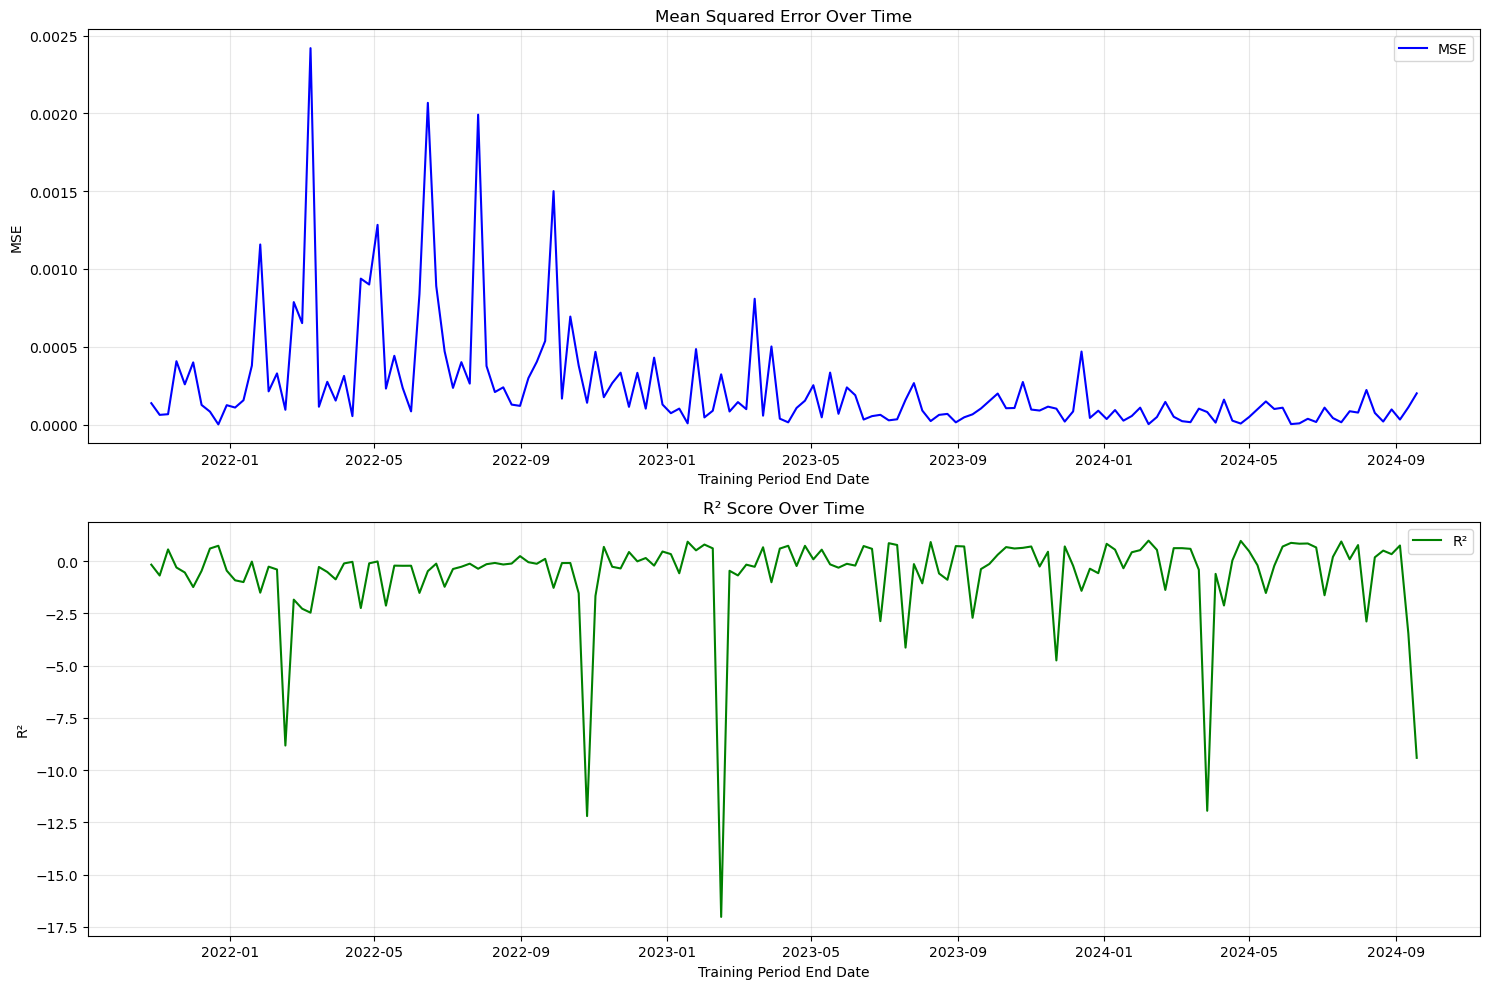

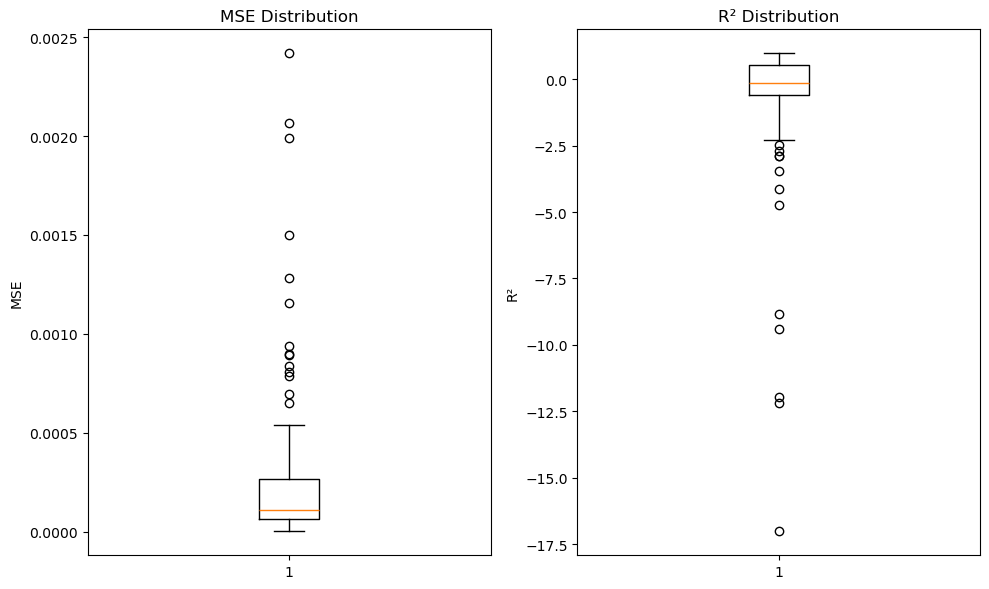


Metrics Summary:
MSE - Mean: 0.000247, Std: 0.000370
MSE - Min: 0.000001, Max: 0.002419
R² - Mean: -0.632292, Std: 2.364588
R² - Min: -17.022860, Max: 0.982508


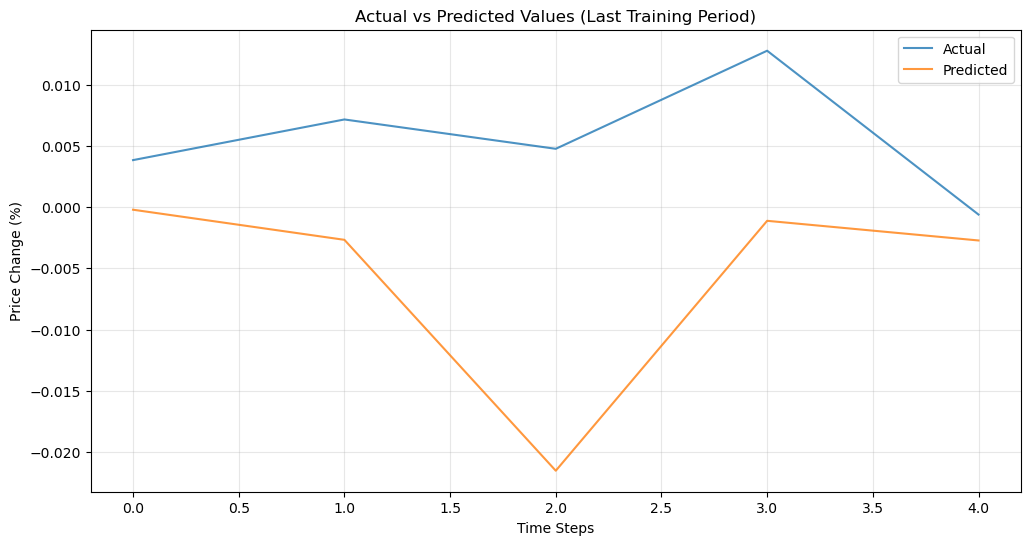

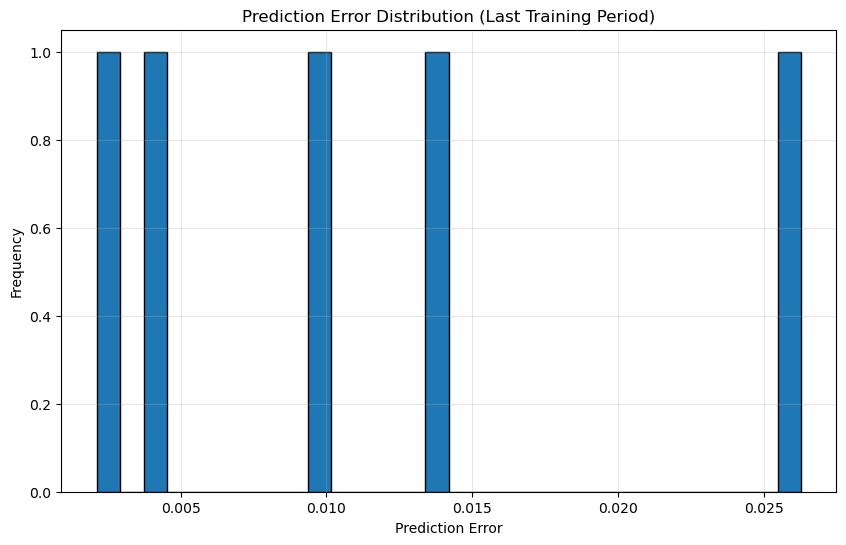

In [38]:
# Create figure for metrics over time
plt.figure(figsize=(15, 10))

# Plot 1: MSE over time
plt.subplot(2, 1, 1)
dates = [pd.to_datetime(m['period'][1], unit='ms') for m in all_metrics]
mse_values = [m['mse'] for m in all_metrics]
plt.plot(dates, mse_values, 'b-', label='MSE')
plt.title('Mean Squared Error Over Time')
plt.xlabel('Training Period End Date')
plt.ylabel('MSE')
plt.grid(True, alpha=0.3)
plt.legend()

# Plot 2: R2 over time
plt.subplot(2, 1, 2)
r2_values = [m['r2'] for m in all_metrics]
plt.plot(dates, r2_values, 'g-', label='R²')
plt.title('R² Score Over Time')
plt.xlabel('Training Period End Date')
plt.ylabel('R²')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

# Create box plots of the metrics
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.boxplot(mse_values)
plt.title('MSE Distribution')
plt.ylabel('MSE')

plt.subplot(1, 2, 2)
plt.boxplot(r2_values)
plt.title('R² Distribution')
plt.ylabel('R²')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nMetrics Summary:")
print(f"MSE - Mean: {np.mean(mse_values):.6f}, Std: {np.std(mse_values):.6f}")
print(f"MSE - Min: {np.min(mse_values):.6f}, Max: {np.max(mse_values):.6f}")
print(f"R² - Mean: {np.mean(r2_values):.6f}, Std: {np.std(r2_values):.6f}")
print(f"R² - Min: {np.min(r2_values):.6f}, Max: {np.max(r2_values):.6f}")

# Plot predictions vs actual for a sample period (last period)
last_split = splits[-1]
model.eval()
with torch.no_grad():
    val_predictions = model(last_split['X_val']).cpu().numpy()
    val_actual = last_split['y_val'].cpu().numpy()
    
    # Denormalize predictions and actual values
    val_predictions = last_split['scalers'][1].inverse_transform(val_predictions)
    val_actual = last_split['scalers'][1].inverse_transform(val_actual)

plt.figure(figsize=(12, 6))
plt.plot(val_actual, label='Actual', alpha=0.8)
plt.plot(val_predictions, label='Predicted', alpha=0.8)
plt.title('Actual vs Predicted Values (Last Training Period)')
plt.xlabel('Time Steps')
plt.ylabel('Price Change (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Calculate and plot prediction error distribution
errors = val_actual - val_predictions
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, edgecolor='black')
plt.title('Prediction Error Distribution (Last Training Period)')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()


Trading Strategy Results:
Initial Investment: $10,000
Final Portfolio Value: $9210.48
Strategy Return: -7.90%
Buy & Hold Return: -10.32%
Stock Price Change: -12.73%
Number of Trades: 25
Average Return per Trade: -0.31%
Prediction Direction Accuracy: 62.00%


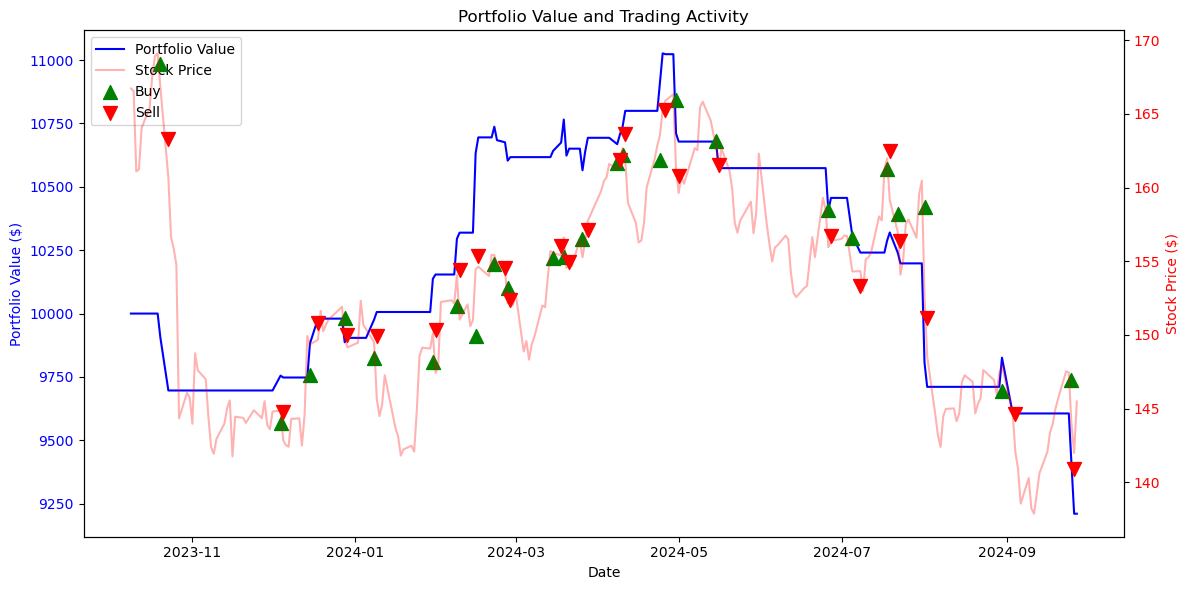

In [50]:
# Get the last year of data
last_year_date = df['Date'].max() - one_year_unix
last_year_data = df[df['Date'] >= last_year_date].copy()

# Initialize variables for tracking performance
initial_investment = 10000  # Starting with $10,000
current_position = None    # 'long' or None
entry_price = 0
trades = []  # Will store dictionaries with trade information
daily_values = []

def naive_trading_strategy(last_year_data, X, model, splits):
    # For each day in the last year
    for i in range(len(last_year_data) - 1):
        current_day = last_year_data.iloc[i]
        next_day = last_year_data.iloc[i + 1]
        
        # Prepare input data for prediction
        input_data = X[X['Date'] == current_day['Date']]
        
        # Scale the input data using the last split's scaler
        input_scaled = splits[-1]['scalers'][0].transform(input_data)
        input_tensor = torch.FloatTensor(input_scaled).to(device)
        
        # Make prediction (this gives us predicted percent change)
        model.eval()
        with torch.no_grad():
            prediction_pct = model(input_tensor).cpu().numpy()
            prediction_pct = splits[-1]['scalers'][1].inverse_transform(prediction_pct)[0][0]
            
            # Convert percent change to predicted price
            predicted_price = current_day['Close'] * (1 + prediction_pct)
        
        # Trading logic (now comparing actual prices)
        next_day_open = next_day['Open']
        next_day_close = next_day['Close']
        
        if predicted_price > next_day_open:  # Bullish prediction
            if current_position is None:  # If not in position, buy
                entry_price = next_day_open
                current_position = 'long'
                trades.append({
                    'date': pd.to_datetime(next_day['Date'], unit='ms'),
                    'action': 'buy',
                    'price': entry_price,
                    'predicted_price': predicted_price,
                    'actual_price': next_day_close,
                    'returns': 0.0
                })
        elif predicted_price < next_day_open:  # Bearish prediction
            if current_position == 'long':  # If in position, sell
                exit_price = next_day_open
                returns = (exit_price - entry_price) / entry_price
                initial_investment *= (1 + returns)
                current_position = None
                trades.append({
                    'date': pd.to_datetime(next_day['Date'], unit='ms'),
                    'action': 'sell',
                    'price': exit_price,
                    'predicted_price': predicted_price,
                    'actual_price': next_day_close,
                    'returns': returns * 100
                })
        
        # Track daily portfolio value
        daily_value = initial_investment
        if current_position == 'long':
            daily_value = initial_investment * (1 + (next_day_close - entry_price) / entry_price)
        
        daily_values.append({
            'date': pd.to_datetime(next_day['Date'], unit='ms'),
            'portfolio_value': daily_value,
            'stock_price': next_day_close
        })

    # Close any open position at the end
    if current_position == 'long':
        exit_price = last_year_data.iloc[-1]['Close']
        returns = (exit_price - entry_price) / entry_price
        initial_investment *= (1 + returns)
        trades.append({
            'date': pd.to_datetime(last_year_data.iloc[-1]['Date'], unit='ms'),
            'action': 'sell',
            'price': exit_price,
            'predicted_price': predicted_price,
            'actual_price': exit_price,
            'returns': returns * 100
        })

    # Create DataFrames
    trades_df = pd.DataFrame(trades)
    daily_values_df = pd.DataFrame(daily_values)

    return trades_df, daily_values_df

def MA_Crossover_strategy(last_year_data, X, model, splits):
    # Get the last year + 20 days of data to account for MA calculation
    last_year_date = df['Date'].max() - one_year_unix - (20 * 24 * 60 * 60 * 1000)  # Subtract 20 days in milliseconds
    last_year_data = df[df['Date'] >= last_year_date].copy()

    # Add moving averages
    last_year_data['SMA5'] = last_year_data['Close'].rolling(window=5).mean()
    last_year_data['SMA20'] = last_year_data['Close'].rolling(window=20).mean()

    # Initialize variables
    initial_investment = 10000
    current_position = None
    entry_price = 0
    trades = []
    daily_values = []

    # For each day in the last year
    for i in range(20, len(last_year_data) - 1):  # Start after moving averages are established
        current_day = last_year_data.iloc[i]
        next_day = last_year_data.iloc[i + 1]
        
        # Get model prediction
        input_data = X[X['Date'] == current_day['Date']]
        
        if len(input_data) == 0:  # Skip if no matching data found
            continue
            
        input_scaled = splits[-1]['scalers'][0].transform(input_data)
        input_tensor = torch.FloatTensor(input_scaled).to(device)
        
        model.eval()
        with torch.no_grad():
            prediction_pct = model(input_tensor).cpu().numpy()
            prediction_pct = splits[-1]['scalers'][1].inverse_transform(prediction_pct)[0][0]
            predicted_price = current_day['Close'] * (1 + prediction_pct)
        
        # Trading logic combining MA crossover and prediction
        next_day_open = next_day['Open']
        next_day_close = next_day['Close']
        
        # Buy signals with additional checks
        buy_signal = (
            current_day['SMA5'] > current_day['SMA20'] and  # MA crossover
            predicted_price > next_day_open and  # Price prediction
            current_day['Close'] > current_day['SMA20'] and  # Trend confirmation
            not pd.isna(current_day['SMA5']) and  # Ensure MAs are not NaN
            not pd.isna(current_day['SMA20'])
        )
        
        # Sell signals with additional checks
        sell_signal = (
            (current_day['SMA5'] < current_day['SMA20'] or
            predicted_price < next_day_open or
            current_day['Close'] < current_day['SMA5']) and
            not pd.isna(current_day['SMA5']) and
            not pd.isna(current_day['SMA20'])
        )
        
        if buy_signal and current_position is None:
            entry_price = next_day_open
            current_position = 'long'
            trades.append({
                'date': pd.to_datetime(next_day['Date'], unit='ms'),
                'action': 'buy',
                'price': entry_price,
                'predicted_price': predicted_price,
                'actual_price': next_day_close,
                'ma_signal': current_day['SMA5'] > current_day['SMA20'],
                'prediction_signal': predicted_price > next_day_open,
                'returns': 0.0
            })
        elif sell_signal and current_position == 'long':
            exit_price = next_day_open
            returns = (exit_price - entry_price) / entry_price
            initial_investment *= (1 + returns)
            current_position = None
            trades.append({
                'date': pd.to_datetime(next_day['Date'], unit='ms'),
                'action': 'sell',
                'price': exit_price,
                'predicted_price': predicted_price,
                'actual_price': next_day_close,
                'ma_signal': current_day['SMA5'] < current_day['SMA20'],
                'prediction_signal': predicted_price < next_day_open,
                'returns': returns * 100
            })
        
        # Track daily portfolio value
        daily_value = initial_investment
        if current_position == 'long':
            daily_value = initial_investment * (1 + (next_day_close - entry_price) / entry_price)
        
        daily_values.append({
            'date': pd.to_datetime(next_day['Date'], unit='ms'),
            'portfolio_value': daily_value,
            'stock_price': next_day_close,
            'SMA5': current_day['SMA5'],
            'SMA20': current_day['SMA20']
        })

    # Close any open position at the end
    if current_position == 'long':
        exit_price = last_year_data.iloc[-1]['Close']
        returns = (exit_price - entry_price) / entry_price
        initial_investment *= (1 + returns)
        trades.append({
            'date': pd.to_datetime(last_year_data.iloc[-1]['Date'], unit='ms'),
            'action': 'sell',
            'price': exit_price,
            'predicted_price': predicted_price,
            'actual_price': exit_price,
            'ma_signal': False,
            'prediction_signal': False,
            'returns': returns * 100
        })

    trades_df = pd.DataFrame(trades)
    daily_values_df = pd.DataFrame(daily_values)

    return trades_df, daily_values_df, initial_investment  # Added initial_investment to return values

def plot_portfolio_and_stock(trades_df, daily_values_df, initial_investment):
    # Print results
    print(f"\nTrading Strategy Results:")
    print(f"Initial Investment: $10,000")
    print(f"Final Portfolio Value: ${initial_investment:.2f}")
    print(f"Total Return: {((initial_investment - 10000) / 10000 * 100):.2f}%")

    if len(daily_values_df) > 0:
        # Calculate absolute price difference over the year
        start_price = daily_values_df.iloc[0]['stock_price']
        end_price = daily_values_df.iloc[-1]['stock_price']
        price_diff = end_price - start_price
        print(f"Percent Price Difference of Stock Over Year: {price_diff / start_price * 100:.2f}%")

    if len(trades_df) > 0:
        print(f"Number of Trades: {len(trades_df[trades_df['action'] == 'buy'])}")
        print(f"Average Return per Trade: {trades_df[trades_df['action'] == 'sell']['returns'].mean():.2f}%")
        
        # Calculate prediction accuracy metrics
        trades_df['prediction_direction'] = (trades_df['predicted_price'] > trades_df['price']) == (trades_df['actual_price'] > trades_df['price'])
        accuracy = trades_df['prediction_direction'].mean() * 100
        print(f"Prediction Direction Accuracy: {accuracy:.2f}%")

    # Create new figure
    plt.figure(figsize=(12, 6))

    # Create subplot with two y-axes
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot portfolio value
    ax1.plot(daily_values_df['date'], daily_values_df['portfolio_value'], 
            'b-', label='Portfolio Value')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Portfolio Value ($)', color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    # Plot stock price on secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(daily_values_df['date'], daily_values_df['stock_price'], 
            'r-', alpha=0.3, label='Stock Price')
    ax2.set_ylabel('Stock Price ($)', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    if len(trades_df) > 0:
        # Plot buy/sell markers
        buy_trades = trades_df[trades_df['action'] == 'buy']
        if len(buy_trades) > 0:
            ax2.scatter(buy_trades['date'], buy_trades['price'], 
                    color='green', marker='^', s=100, label='Buy')
        
        sell_trades = trades_df[trades_df['action'] == 'sell']
        if len(sell_trades) > 0:
            ax2.scatter(sell_trades['date'], sell_trades['price'], 
                    color='red', marker='v', s=100, label='Sell')

    # Add legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    plt.title('Portfolio Value and Trading Activity')
    plt.tight_layout()
    plt.show()

    # Display trade log with predictions
    # if len(trades_df) > 0:
        # print("\nDetailed Trade Log:")
        # print(trades_df[['date', 'action', 'price', 'predicted_price', 'actual_price', 'returns', 'prediction_direction']])

# trades_df, daily_values_df = naive_trading_strategy(last_year_data, X, model, splits)
trades_df, daily_values_df, initial_investment = MA_Crossover_strategy(last_year_data, X, model, splits)
plot_portfolio_and_stock(trades_df, daily_values_df, initial_investment)

In [9]:
# Import necessary libraries
import yfinance as yf
from datetime import datetime, timedelta

# Get the latest data for the stock
ticker = "CVX"
end_date = datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.now() - timedelta(days=60)).strftime('%Y-%m-%d')  # Get 60 days of data

# Fetch the data
df = yf.download(ticker, start=start_date, end=end_date)

# Prepare the input data (use the same feature engineering as in training)
latest_data = df.tail(1).copy()  # Get only the last row
latest_data['Date'] = (latest_data.index.astype('int64') / 10**6).astype('int64')

# Ensure we have the same columns as during training
for col in X_train.columns:
    if col not in latest_data.columns:
        latest_data[col] = 0  # or some appropriate default value

# Reorder columns to match training data
latest_data = latest_data[X_train.columns]

# Scale the data using the same scaler used for training
latest_scaled = scaler.transform(latest_data)

# Convert to tensor
latest_tensor = torch.FloatTensor(latest_scaled).to(device)

# Make prediction
model.eval()
with torch.no_grad():
    prediction = model(latest_tensor).item()

# Denormalize the prediction
predicted_price = prediction * y_train.std() + y_train.mean()

print(f"Predicted close price for {ticker} on {(datetime.now() + timedelta(days=1)).strftime('%Y-%m-%d')}: ${predicted_price:.2f}")


[*********************100%***********************]  1 of 1 completed

Predicted close price for CVX on 2024-11-22: $2105.39



c:\Users\kchen\miniforge3\envs\StockRegression\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
